In [1]:
import numpy as np

In [3]:
import pandas as pd
df = pd.read_csv("/content/TSLA_historical_data.csv")

In [4]:
prices = df['Adj Close']

# Split data into train and test sets
train_size = int(len(prices) * 0.8)
train, test = prices[:train_size], prices[train_size:]

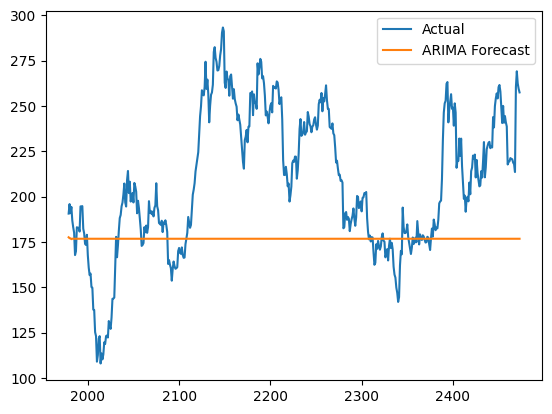

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Train ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # Adjust (p, d, q) as needed
arima_model = model.fit()

# Forecasting
forecast = arima_model.forecast(steps=len(test))
plt.plot(test, label="Actual")
plt.plot(forecast, label="ARIMA Forecast")
plt.legend()
plt.show()

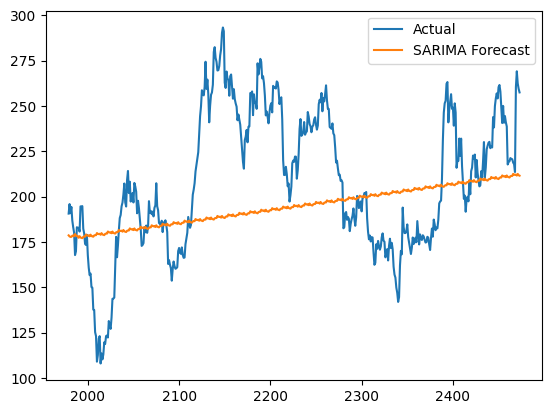

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# Forecasting
sarima_forecast = sarima_model.forecast(steps=len(test))
plt.plot(test, label="Actual")
plt.plot(sarima_forecast, label="SARIMA Forecast")
plt.legend()
plt.show()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0300
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0013
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 9.5898e-04
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 8.7741e-04
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 7.0136e-04
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 6.4857e-04
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 5.9626e-04
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.5681e-04
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 7.5089e-04
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


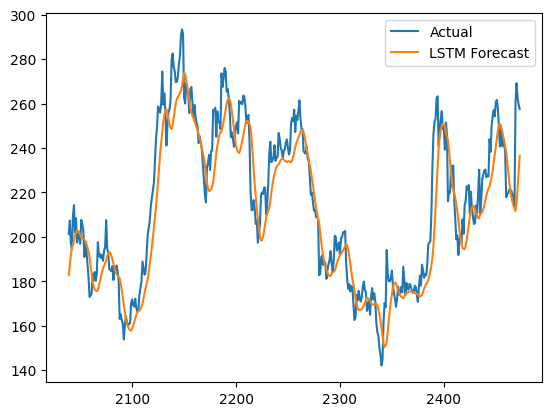

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(np.array(train).reshape(-1, 1))
test_scaled = scaler.transform(np.array(test).reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Forecast
X_test, _ = create_sequences(test_scaled)
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

plt.plot(test.iloc[60:], label="Actual")
plt.plot(test.index[60:], lstm_forecast, label="LSTM Forecast")
plt.legend()
plt.show()

In [10]:
from pmdarima import auto_arima

#ARIMA parameters
auto_arima_model = auto_arima(train, seasonal=False, trace=True, stepwise=True)
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=6.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=1.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=5.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 15.030 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1979
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6168.668
Date:                Mon, 11 Nov 2024   AIC                          12339.337
Time:                        10:28:58   BIC                          12344.927
Sample:                             0   HQIC                         12341.391
   

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation for ARIMA or SARIMA
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 39.31325191344551
RMSE: 49.56620023141533
MAPE: 17.768733134316463%


#### ARIMA Forecasting

Forecast Head:
 1979    177.678130
1980    177.159613
1981    177.093947
1982    176.654713
1983    176.892897
Name: Forecast, dtype: float64
Confidence Interval Head:
       Lower Bound  Upper Bound
1979   166.971856   188.384404
1980   162.300395   192.018830
1981   158.900429   195.287464
1982   155.644205   197.665222
1983   153.213235   200.572559


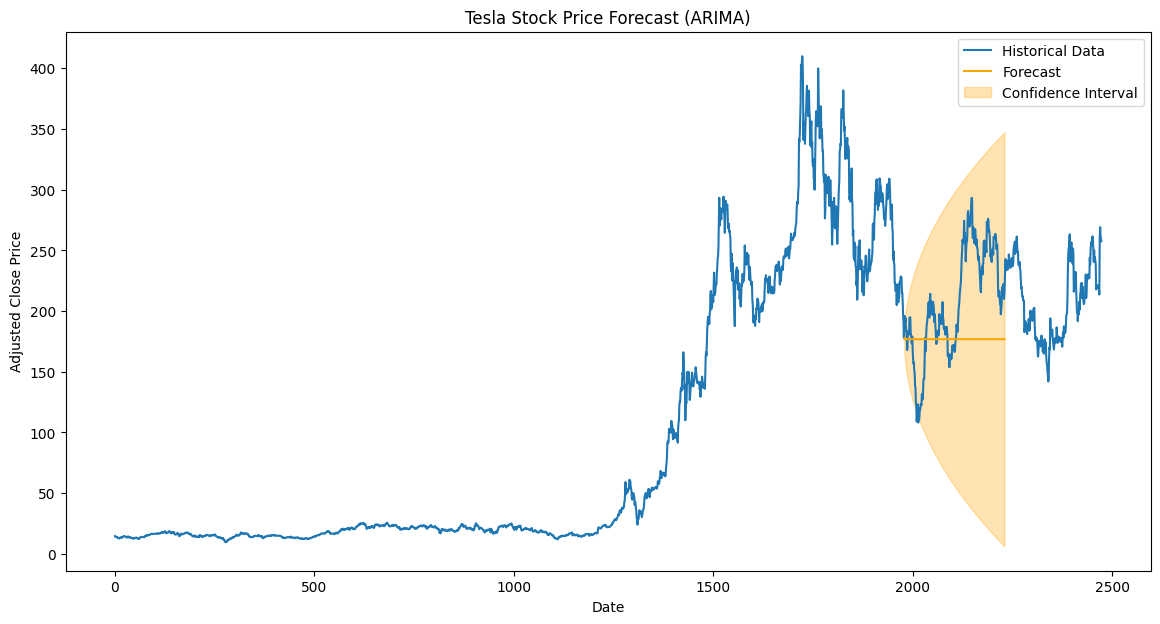

In [13]:
forecast_steps = 252
forecast_result = arima_model.get_forecast(steps=forecast_steps)
forecast = pd.Series(forecast_result.predicted_mean, name="Forecast")

# Retrieve confidence intervals and ensure correct column names
conf_int = forecast_result.conf_int()
conf_int.columns = ["Lower Bound", "Upper Bound"]

# Check the content of forecast and confidence intervals again
print("Forecast Head:\n", forecast.head())
print("Confidence Interval Head:\n", conf_int.head())

# Proceed with plotting if conf_int is now correctly populated
if not forecast.empty and not conf_int.empty and len(forecast) == len(conf_int):
    plt.figure(figsize=(14, 7))
    plt.plot(prices, label="Historical Data")
    plt.plot(forecast.index, forecast, label="Forecast", color="orange")
    plt.fill_between(forecast.index, conf_int["Lower Bound"], conf_int["Upper Bound"], color="orange", alpha=0.3, label="Confidence Interval")
    plt.title("Tesla Stock Price Forecast (ARIMA)")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.show()
else:
    print("Forecast or confidence interval data are still empty or misaligned after processing.")

#### LSTM Forecasting

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


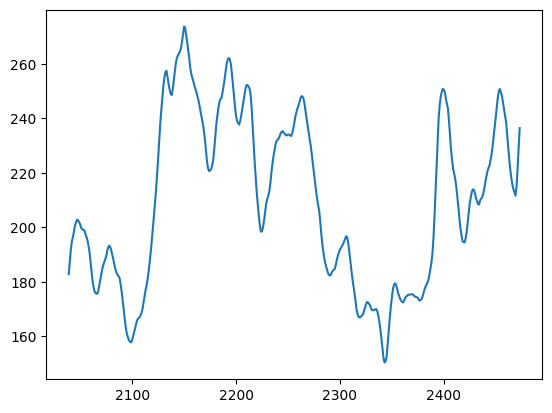

In [15]:
# Forecast for next 252 steps (approx. 12 months)
lstm_forecast = model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)  # Inverse scaling

# Plot actual vs predicted for test set
plt.plot(test.index[60:], lstm_forecast, label="LSTM Forecast")